In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa  # for F1 Score
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

C:\Users\ranam\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\ranam\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 5505 files belonging to 6 classes.


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [5]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])

In [9]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # integer labels
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
138/138 [==============================] - 208s 1s/step - loss: 1.2041 - accuracy: 0.5450 - val_loss: 0.4624 - val_accuracy: 0.8548
Epoch 2/10
138/138 [==============================] - 192s 1s/step - loss: 0.5441 - accuracy: 0.8146 - val_loss: 0.2824 - val_accuracy: 0.8915
Epoch 3/10
138/138 [==============================] - 194s 1s/step - loss: 0.3559 - accuracy: 0.8782 - val_loss: 0.2350 - val_accuracy: 0.9136
Epoch 4/10
138/138 [==============================] - 196s 1s/step - loss: 0.2745 - accuracy: 0.9049 - val_loss: 0.1021 - val_accuracy: 0.9614
Epoch 5/10
138/138 [==============================] - 190s 1s/step - loss: 0.2156 - accuracy: 0.9273 - val_loss: 0.1510 - val_accuracy: 0.9467
Epoch 6/10
138/138 [==============================] - 190s 1s/step - loss: 0.1644 - accuracy: 0.9416 - val_loss: 0.0400 - val_accuracy: 0.9871
Epoch 7/10
138/138 [==============================] - 188s 1s/step - loss: 0.1516 - accuracy: 0.9466 - val_loss: 0.0770 - val_accuracy: 0.9724

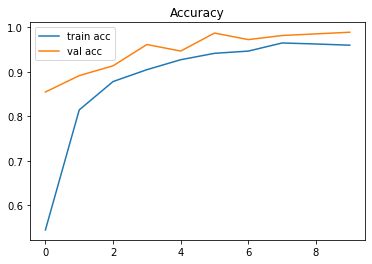

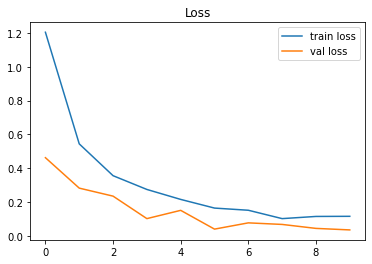

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

18/18 [==============================] - 15s 251ms/step - loss: 0.0559 - accuracy: 0.9792
Test Loss: 0.055875759571790695
Test Accuracy: 0.9791666865348816


1/1 [==============================] - 0s 260ms/step


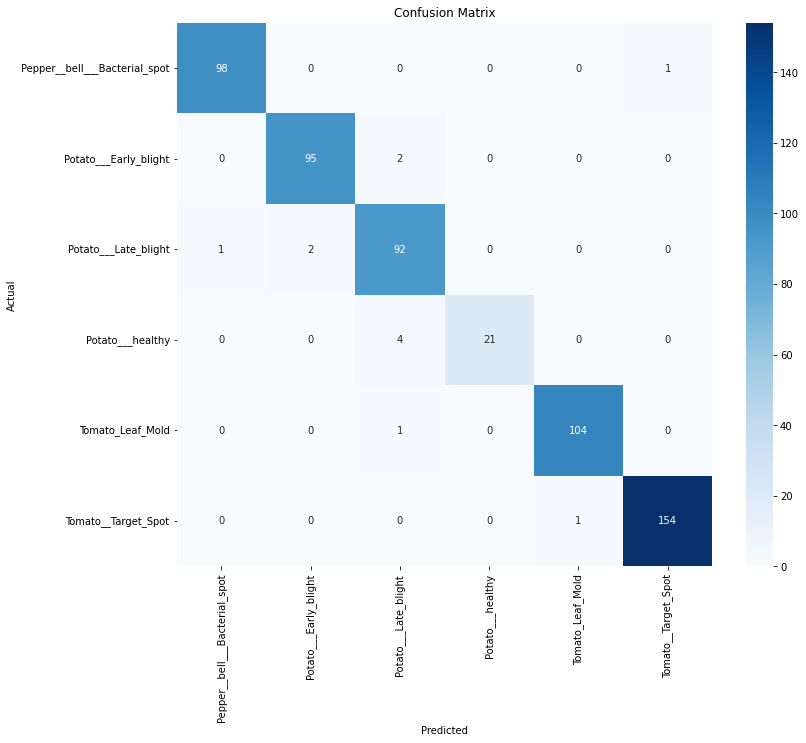

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.99      0.99      0.99        99
        Potato___Early_blight       0.98      0.98      0.98        97
         Potato___Late_blight       0.93      0.97      0.95        95
             Potato___healthy       1.00      0.84      0.91        25
             Tomato_Leaf_Mold       0.99      0.99      0.99       105
          Tomato__Target_Spot       0.99      0.99      0.99       155

                     accuracy                           0.98       576
                    macro avg       0.98      0.96      0.97       576
                 weighted avg       0.98      0.98      0.98       576

Macro F1 Score: 0.9691336828798692
Weighted F1 Score: 0.9790437148264357


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

print("Macro F1 Score:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1 Score:", f1_score(y_true, y_pred, average='weighted'))
